In [53]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.feature
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler # this is for normalising our data
import sklearn.cluster
import sklearn.mixture
import tensorflow.keras as keras
import tensorflow as tf
import time

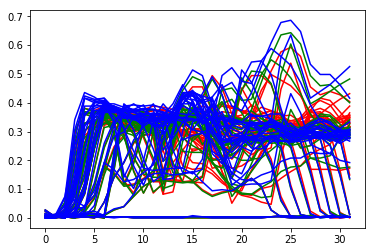

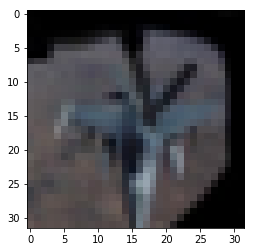

In [4]:
trnImages = np.load('trnImage.npy')
testImages = np.load('tstImage.npy')
testLabel = np.load('tstLabel.npy')
trnLabel = np.load('trnLabel.npy')
trnidx = 10
plt.figure()
plt.plot(trnImages[:,:,:,trnidx][:,:, 0], c='r', label='Red')
plt.plot(trnImages[:,:,:,trnidx][:,:, 1],  c='g', label='Green')
plt.plot(trnImages[:,:,:,trnidx][:,:, 2], c='b', label='Blue')
img = np.copy(trnImages[:,:,:,trnidx][:,:,:])
plt.show()

plt.imshow(trnImages[:,:,:,trnidx])

In [7]:
def computeFeatures(image):
    # This function computes the HOG features with the parsed hyperparameters and returns the features as hog_feature. 
    # By setting visualize=True we obtain an image, hog_as_image, which can be plotted for insight into extracted HOG features.
    hog_feature, hog_as_image = skimage.feature.hog(image, visualize=True, block_norm='L2-Hys')
    return hog_feature, hog_as_image

def computeFeaturesOnly(image):
    # This function computes the HOG features with the parsed hyperparameters and returns the features as hog_feature. 
    # By setting visualize=True we obtain an image, hog_as_image, which can be plotted for insight into extracted HOG features.
    hog_features, _ = skimage.feature.hog(image, visualize=True, block_norm='L2-Hys')
    return hog_features

def genFeatureMatrix(m):
    featureMatrix = np.zeros((m.shape[-1], 324))
    for i in range(m.shape[-1]):
        featureMatrix[i] = computeFeaturesOnly(m[:,:,:,i])
    return featureMatrix

In [8]:
trnImageFeatures = genFeatureMatrix(trnImages)
testImageFeatures = genFeatureMatrix(testImages)

(10000,)


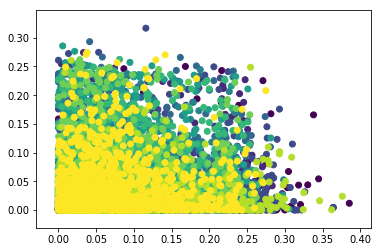

In [50]:
print(trnLabel[:, 0].shape)
plt.scatter(trnImageFeatures[:, 150], trnImageFeatures[:,1], c=trnLabel[:, 0])

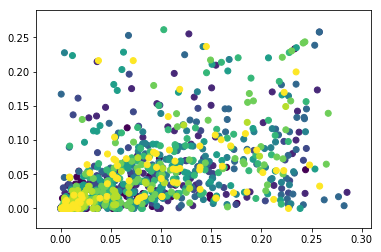

In [6]:
plt.scatter(testImageFeatures[:, 0], testImageFeatures[:,1], c=testLabel[:, 0])

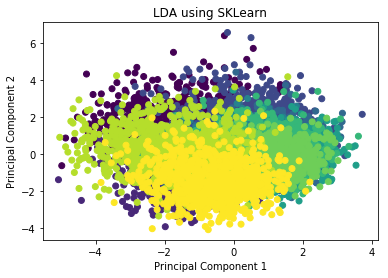

In [92]:
lda = LinearDiscriminantAnalysis()
lda.fit(trnImageFeatures, trnLabel[:, 0])
trnImageFeaturesProjectedLDAAllComps = lda.transform(trnImageFeatures)
testImageFeaturesProjectedLDAAllComps = lda.transform(testImageFeatures)
plt.scatter(trnImageFeaturesProjectedLDAAllComps[:, 0], trnImageFeaturesProjectedLDAAllComps[:, 1], c=trnLabel[:, 0])
plt.xlabel('Principal Component 1') 
plt.ylabel("Principal Component 2") 
plt.title("LDA using SKLearn")
plt.show()

In [73]:
predicted_labels = lda.predict(testImageFeatures)
np.sum(np.equal(testLabel[:,0], predicted_labels)) / testLabel[:,0].shape[0] * 100


49.4

[38.37982713 18.71299004 13.60273773  8.20777812  5.64234729  4.90628214
  4.14471225  3.38134962  3.02197567]
(6,)


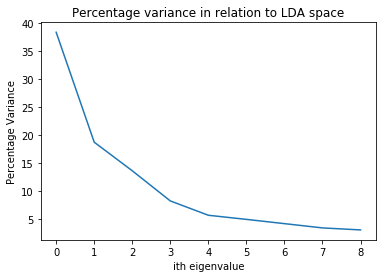

In [58]:
plt.figure()
plt.plot(lda.explained_variance_ratio_*100)
var_ratio = lda.explained_variance_ratio_
print(lda.explained_variance_ratio_*100)
print(var_ratio[np.cumsum(var_ratio*100)<90].shape)
plt.title("Percentage variance in relation to LDA space")
plt.xlabel("ith eigenvalue")
plt.ylabel("Percentage Variance")
plt.show()

Text(0.5, 1.0, 'LDA using SKLearn')

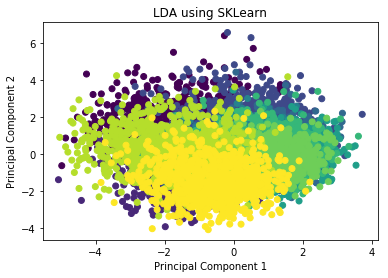

In [59]:
lda_reduced_comps = LinearDiscriminantAnalysis(n_components=6)
lda_reduced_comps.fit(trnImageFeatures, trnLabel[:, 0])
trnImageFeaturesProjected = lda_reduced_comps.transform(trnImageFeatures)
testImageFeaturesProjected = lda_reduced_comps.transform(testImageFeatures)
plt.scatter(trnImageFeaturesProjected[:, 0], trnImageFeaturesProjected[:, 1], c=trnLabel[:, 0])
plt.xlabel('Principal Component 1') 
plt.ylabel("Principal Component 2") 
plt.title("LDA using SKLearn")

In [60]:
predicted_labels = lda_reduced_comps.predict(testImageFeatures)
np.sum(np.equal(testLabel[:,0], predicted_labels)) / testLabel[:,0].shape[0] * 100


49.4

In [51]:
pca = PCA()
pca.fit(trnImageFeatures)
trnImageFeaturesProjected = pca.transform(trnImageFeatures)

# plt.scatter(new_x[:, 0], new_x[:, 1], c=y)
# plt.xlabel("Principal Component 1")
# plt.ylabel("Principal Component 2")
# plt.title("PCA using SKLearn")

(70,)


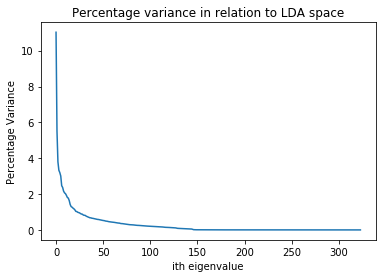

In [53]:
# print(pca.explained_variance_ratio_* 100)
variance_ratio = pca.explained_variance_ratio_
print(variance_ratio[np.cumsum(variance_ratio*100)<86].shape)
plt.plot(pca.explained_variance_ratio_*100)
plt.title("Percentage variance in relation to LDA space")
plt.xlabel("ith eigenvalue")
plt.ylabel("Percentage Variance")
plt.show()

Text(0.5, 1.0, 'LDA using SKLearn')

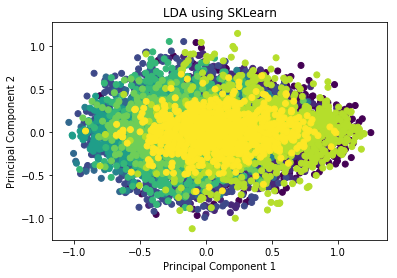

In [54]:
pcaModel = PCA(n_components=70)
pcaModel.fit(trnImageFeatures)
trnImageFeaturesProjected = pcaModel.transform(trnImageFeatures)
plt.scatter(trnImageFeaturesProjected[:, 0], trnImageFeaturesProjected[:, 1], c=trnLabel[:, 0])
plt.xlabel('Principal Component 1') 
plt.ylabel("Principal Component 2") 
plt.title("PCA using SKLearn")


In [84]:
kpcaModel = KernelPCA(kernel="poly", degree=100)
kpcaModel.fit(trnImageFeatures)

KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=100, eigen_solver='auto',
     fit_inverse_transform=False, gamma=None, kernel='poly',
     kernel_params=None, max_iter=None, n_components=None, n_jobs=None,
     random_state=None, remove_zero_eig=False, tol=0)

[1.06371127e+03 5.36436613e+02 3.73923206e+02 ... 1.15871485e-02
 1.14554893e-02 1.09734889e-02]
(298,)
(9999,)


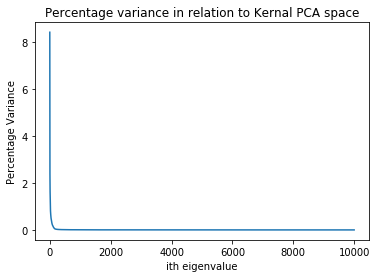

In [87]:
eigenvalues = kpcaModel.lambdas_
print(eigenvalues)
eig_ratios = eigenvalues/np.sum(eigenvalues)
plt.plot(eig_ratios*100)
plt.title("Percentage variance in relation to Kernal PCA space")
plt.xlabel("ith eigenvalue")
plt.ylabel("Percentage Variance")
print(eigenvalues[np.cumsum(eig_ratios*100)<85].shape)
print(eigenvalues.shape)
# variance_ratio[np.cumsum(variance_ratio*100)<91].shape

Text(0.5, 1.0, 'KPCA using SKLearn')

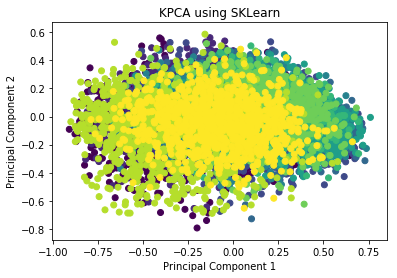

In [88]:
kpcaModel = KernelPCA(n_components=70, kernel="poly", degree=5)
kpcaModel.fit(trnImageFeatures)
trnImageFeaturesProjected = kpcaModel.transform(trnImageFeatures)
plt.scatter(trnImageFeaturesProjected[:, 0], trnImageFeaturesProjected[:, 2], c=trnLabel[:, 0])
plt.xlabel('Principal Component 1') 
plt.ylabel("Principal Component 2") 
plt.title("KPCA using SKLearn")

Text(0.5, 1.0, 'KPCA using SKLearn')

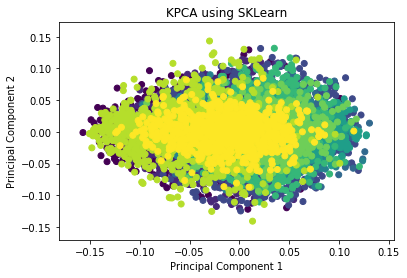

In [77]:
plt.scatter(trnImageFeaturesProjected[:, 0], trnImageFeaturesProjected[:, 1], c=trnLabel[:, 0])
plt.xlabel('Principal Component 1') 
plt.ylabel("Principal Component 2") 
plt.title("KPCA using SKLearn")

In [102]:
calAccTimeSVMModels(trnImageFeatures, testImageFeatures, trnLabel, testLabel, 2, 10, 1)

([[57.599999999999994, 46.907026052474976],
  [55.900000000000006, 55.04271697998047],
  [44.4, 67.27047896385193],
  [32.4, 68.473149061203],
  [22.2, 68.87129712104797],
  [16.5, 70.31528902053833],
  [14.099999999999998, 71.6651062965393],
  [12.4, 71.70062208175659],
  [11.200000000000001, 80.82308912277222]],
 [[48.5, 128.09216213226318]])

In [106]:
def calAccTimeSVMModels(trnFeatures, testFeatures, trnLabel, tstLabel, min_c, max_c, step):
    normaliser = StandardScaler().fit(trnFeatures)
    trainData = normaliser.transform(trnFeatures)
    testData = normaliser.transform(testFeatures)
    degreeValues = np.arange(min_c,max_c+1, step)
    acc = []
    for index,degree in enumerate(degreeValues):
        start = time.time()
        model = SVC(kernel='poly', degree=degree)#*
        model.fit(trainData, trnLabel[:, 0])
        predicted_labels = model.predict(testData)
        end = time.time()
        timeTaken = end - start
        acc.append([np.sum(np.equal(tstLabel[:, 0], predicted_labels)) / tstLabel[:, 0].shape[0] * 100, timeTaken])
    acc_dim_linear = []
    start = time.time()
    model = SVC(kernel='linear')#*
    model.fit(trainData, trnLabel[:, 0])
    predicted_labels = model.predict(testData)
    end = time.time()
    timeTaken = end - start
    return {'poly': acc, 'linear': [np.sum(np.equal(tstLabel[:, 0], predicted_labels)) / tstLabel[:, 0].shape[0] * 100, timeTaken]}

In [107]:
calAccTimeSVMModels(trnImageFeaturesProjectedLDAAllComps, testImageFeaturesProjectedLDAAllComps, trnLabel, testLabel, 2, 10, 1)

{'poly': [[39.900000000000006, 2.2254128456115723],
  [49.4, 1.8414781093597412],
  [38.0, 2.811866283416748],
  [45.2, 2.349867105484009],
  [34.9, 3.0365278720855713],
  [40.0, 2.8509457111358643],
  [33.300000000000004, 3.541121006011963],
  [35.8, 3.231703996658325],
  [30.3, 3.7461609840393066]],
 'linear': [49.3, 2.0387110710144043]}

In [108]:
calAccTimeSVMModels(trnImageFeaturesProjected, testImageFeaturesProjected, trnLabel, testLabel, 2, 10, 1)

{'poly': [[37.5, 2.1051011085510254],
  [45.9, 1.7319731712341309],
  [34.5, 2.8586628437042236],
  [39.7, 2.3527019023895264],
  [29.099999999999998, 3.732938051223755],
  [36.6, 2.7698452472686768],
  [28.4, 4.241940975189209],
  [34.2, 3.6124532222747803],
  [27.500000000000004, 4.481070280075073]],
 'linear': [46.9, 1.960282802581787]}

1930.0391461849213


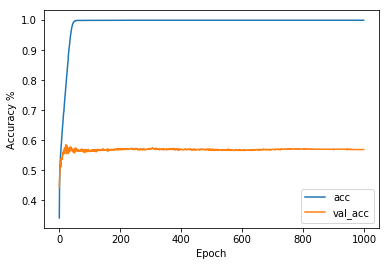

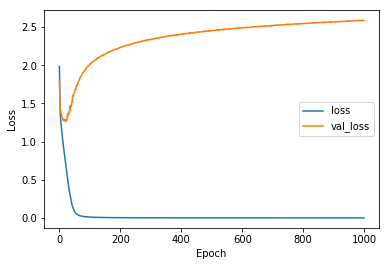

56.89999999999999


In [89]:
def network_train(layers, units, train_data, train_labels, test_data, test_labels, activation='sigmoid', number_of_classes=11):
        # Build our network architecture by stacking layers in a Keras Sequential object.
    start = time.time()
    model = keras.Sequential()

    # Create the input layer, this takes an argument of the input data shape (i.e. number of features)
    model.add(keras.layers.InputLayer(input_shape=(train_data.shape[1],)))

    # Create hidden layers
    for i in range(layers):
        model.add(keras.layers.Dense(units, activation=activation)) 

    # Create output layer to get predicted class labels.
    model.add(keras.layers.Dense(number_of_classes, activation='sigmoid'))

    # Generate a callable keras Model object which contains our architecture.
    # This allows us to train and predict our neural network on the datasets.
    model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['acc'])

    # Fit our model to the data
    history = model.fit(train_data, train_labels, validation_data=(test_data, test_labels), epochs=1000, verbose=0)

    # Predict probabilities of classes for the testing set.
    predicted_probabilities = model.predict(test_data)
    end = time.time()
    print(end-start)
    # Use argmax to get the predicted class label
    predicted_labels = np.argmax(predicted_probabilities, axis=1)
    
    # Calculate the percentage accuracy rate on test set
    accuracy = np.sum(np.equal(test_labels, predicted_labels)) / test_labels.shape[0] * 100
    plot_acc_loss(history)
    return accuracy

def plot_acc_loss(history):
    plt.figure()
    plt.plot(history.history['acc'], label='acc')
    plt.plot(history.history['val_acc'], label='val_acc')
    plt.ylabel('Accuracy %')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.figure()
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    
print(network_train(2, 2*trainData.shape[1], trainData, trnLabel[:, 0], testData, testLabel[:, 0], activation='elu'))

1081.2742002010345


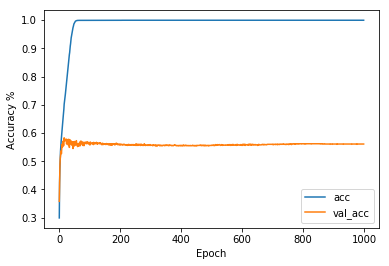

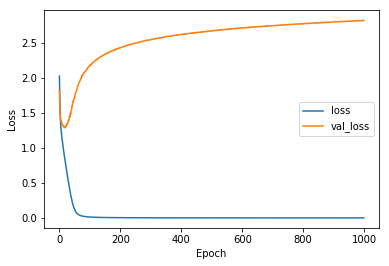

56.10000000000001


In [90]:
print(network_train(2, trainData.shape[1], trainData, trnLabel[:, 0], testData, testLabel[:, 0], activation='elu'))

460.54377698898315


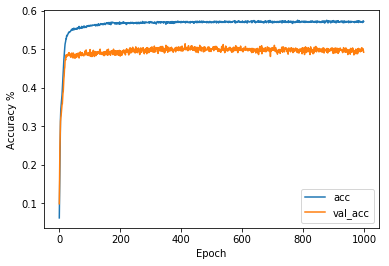

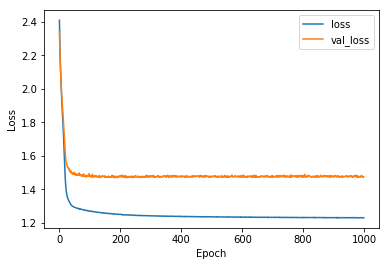

49.2

In [91]:
network_train(2, trainDataProjected.shape[1], trainDataProjected, trnLabel[:, 0], testDataProjected, testLabel[:, 0], activation='elu')

485.8944470882416


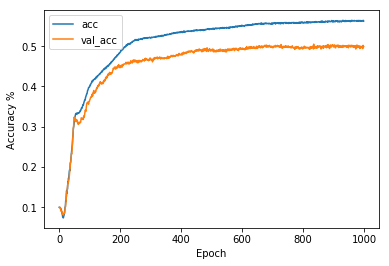

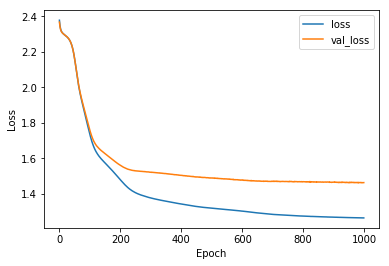

49.9

In [93]:
network_train(2, trainDataProjected.shape[1], trainDataProjected, trnLabel[:, 0], testDataProjected, testLabel[:, 0], activation='sigmoid')

492.96615386009216


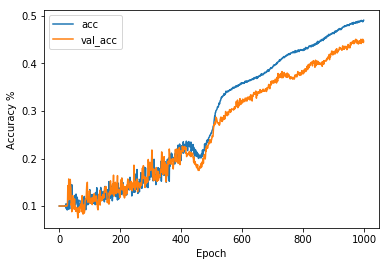

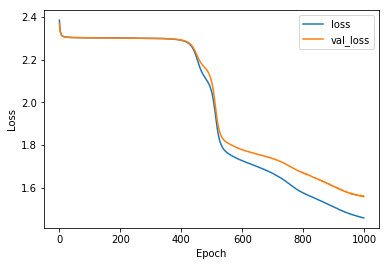

44.7

In [109]:
network_train(4, trainDataProjected.shape[1], trainDataProjected, trnLabel[:, 0], testDataProjected, testLabel[:, 0], activation='sigmoid')

493.77397108078003


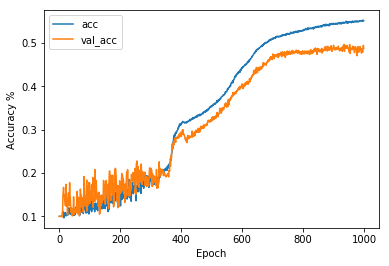

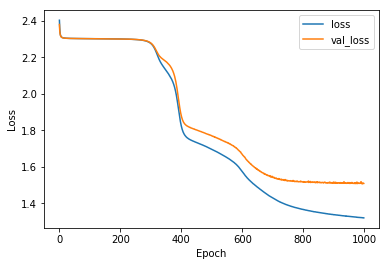

48.8

In [113]:
network_train(4, trainDataProjected.shape[1]*2, trainDataProjected, trnLabel[:, 0], testDataProjected, testLabel[:, 0], activation='sigmoid')